### This Notebook aims to build a CNN Model to predict the numbers from the images of the MNIST Dataset. 

Work FLow:

- Architecture of the network
- Preprocess the data 
- Build and train the network
- Test our Model

### Architecture 

Archutecture of our network: This means to outline what layers we are going to use, how we are going to connect them and what some of the Hyperparameters would be.

Hyperparameters: 
- Kernel Size
- Number of Kernels

Model Architecture:

Conv -> Maxpool -> Conv -> Maxpool -> Flatten -> Dense (10 probabilities)


### Preprocessing the Data

The data we have is Heavily preprocessed. However, we'll apply the following steps:

- Scaling
- Splitting the dataset
- Batching

In [1]:
# Import the libraries

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Downloading and preprocessing the data

BUFFER_SIZE = 70000 #Because the dataset is small we'll keep the buffer size to be equal to the number of images
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [3]:
# We can download the dataset using load() function from the tensorflow library
# load() -> (dataset, meta_info)

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info = True, as_supervised = True) #as_supervised will give download the dataset in a tuple form (input, target)

In [4]:
# Now, the mnist_dataset contains the whole dataset, we have to split it. Its easily achiveable as the mnist dataset is a dictionary with 2 sets labelled train and test

mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [5]:
# We know that the images are in grayscale. Thus, the pixel value ranges from 0-255. We have to standardize it. 
# We'll create a function to achieve this and use this function in conjuction with the map method.

# dataset.map(fn) - apply the function to every element in the dataset.

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    
    return image, label

# We didn't do anything with label but its included in the function as its required to use the map method.

In [6]:
# Map method takes a function and applies it to all elements in the dataset. It does not modify the dataset but returns a new one. Thats why we need a new variable to store it.

train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [7]:
# Mnist does not have a validation dataset. It is very crucial while training. So lets split the dataset
# 10% of training dataset is enough for validation

num_validation_samples = 0.1*mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [8]:
# Now that we have the size of the validation set. We need to take that many samples from the training set and extract them into a different set.
# There is one catch. The dataset is often sorted or odered in some way. 
# So, we'll first shuffle 

train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

train_data = train_and_validation_data.skip(num_validation_samples)
# This will return all the samples except for the first n (num_validation_samples) examples

validation_data = train_and_validation_data.take(num_validation_samples)
# This will do the opposite of skip. It takes the first n samples

In [9]:
# We still need to batch the dataset for optimal performance of the network.

train_data = train_data.batch(BATCH_SIZE)

Batch size is another hyperparameter that can potentially have a big impact on the training time and the final accuracy. As a general rule of thumb a bigger batch size helps speedup the train process. On the other hand, the lower batch size gives better test accuracy. It is desirable to set the batch size to a power of 2.

The validation and tests set don't necesserily need to be batched as we don't backward propogate on them. However, the model expects these to be batched as well to get the proper dimensions. 

That's why we will batch them with the batch size equal to their number if samples.

In [10]:
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

### Build and train the model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation = 'relu', input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(50, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
    
])

In [12]:
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [13]:
# (None, 24, 24, 50) -> None is for batch size

# Softmax is incorporated later into the loss function itself as its impossible to provide a numerically stable loss calculation for all models when using softmax output

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # from_logits will incorporate softmax

model.compile(optimizer = 'adam', loss = loss_fn, metrics = ['accuracy'])

In [14]:
# Before we think about training, we need to think about overfitting.

# In Tensorflow, early stopping is a callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'auto',
                                                  min_delta = 0,
                                                  patience = 2,
                                                  verbose = 0,
                                                  restore_best_weights = True
                                                 )

In [15]:
model.fit(train_data,
          epochs = NUM_EPOCHS,
          callbacks = [early_stopping], # There are more than one callback, so we use a list.
          validation_data = validation_data,
          verbose = 2 # This specifies what to printout during the training process. 2 will print info only at the end of each epoch. 1 will display progress bar for every batch.
         )

Epoch 1/20
422/422 - 32s - loss: 0.2557 - accuracy: 0.9246 - val_loss: 0.0650 - val_accuracy: 0.9810 - 32s/epoch - 76ms/step
Epoch 2/20
422/422 - 31s - loss: 0.0656 - accuracy: 0.9805 - val_loss: 0.0503 - val_accuracy: 0.9843 - 31s/epoch - 73ms/step
Epoch 3/20
422/422 - 29s - loss: 0.0506 - accuracy: 0.9846 - val_loss: 0.0367 - val_accuracy: 0.9880 - 29s/epoch - 69ms/step
Epoch 4/20
422/422 - 29s - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.0332 - val_accuracy: 0.9902 - 29s/epoch - 69ms/step
Epoch 5/20
422/422 - 31s - loss: 0.0351 - accuracy: 0.9896 - val_loss: 0.0312 - val_accuracy: 0.9902 - 31s/epoch - 73ms/step
Epoch 6/20
422/422 - 31s - loss: 0.0295 - accuracy: 0.9909 - val_loss: 0.0218 - val_accuracy: 0.9935 - 31s/epoch - 73ms/step
Epoch 7/20
422/422 - 30s - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0205 - val_accuracy: 0.9932 - 30s/epoch - 72ms/step
Epoch 8/20
422/422 - 35s - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0176 - val_accuracy: 0.9952 - 35s/epoch - 83ms/step


### Testing the model

In [16]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss, test_accuracy * 100.))

1/1 [==============================] - 2s 2s/step - loss: 0.0285 - accuracy: 0.9930
Test Loss:  0.0285. Test accuracy:  99.30%


#### Plotting Images and Results

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

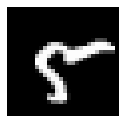

Label: 5


In [23]:
# The image to be displayed and tested
i = 502


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 152ms/step


<BarContainer object of 10 artists>

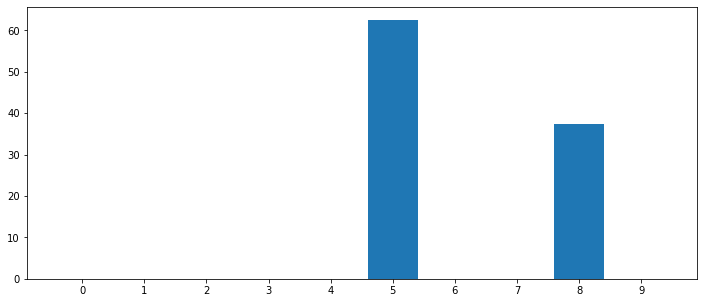

In [24]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])